# Probability Course Project

Modeling the lifetime of nodes in a network using distributions and random reliability.

## Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma, factorial
from scipy.stats import pareto, expon, weibull_min as weibull
from scipy import integrate

## Define Some Functions

### Node Isolation Functions

#### Pareto Distribution

$\pi_r(X)=\frac{k !}{(k-r) !} \cdot \frac{\Gamma\left(k-r+1+\frac{\alpha}{\alpha-1}\right)}{\Gamma\left(k+1+\frac{\alpha}{\alpha-1}\right)}$

$\alpha > 1, \beta > 0$

In [2]:
def pareto_isolation(k, r, alpha):
    assert(alpha > 1)
    return factorial(k) / factorial(k - r) * gamma(k - r + 1 + (alpha / (alpha - 1))) / gamma(k + 1 + (alpha / (alpha - 1)))

#### Exponential Distribution

$\pi_r(X)=\frac{k-r+1}{k+1}$

In [3]:
def exponential_isolation(k, r):
    return (k - r + 1) / (k + 1)

#### Uniform Distribution

$\pi_r(X)=\frac{k !}{(k-r) !} \cdot \frac{\Gamma\left(k-r+1+\frac{3}{2}\right)}{\Gamma\left(k+\frac{3}{2}\right)}$

In [4]:
def uniform_isolation(k, r):
    return factorial(k) / factorial(k - r) * gamma(k - r + 1.5) / gamma(k + 1.5)

### NWUE-ness Comparison Functions

#### Mean residue lifetime

$\mu_F(t)=E[X-t \mid X>t]=\frac{\int_t^{\infty} \bar{F}(x) d x}{\bar{F}(t)}$

In [5]:
def mean_residue_lifetime(survival_function, t):
    return integrate.quad(survival_function, t, np.inf)[0] / survival_function(t)

$\frac{\mu_F\left(F^{-1}(v)\right)}{\mu_G\left(G^{-1}(v)\right)} \geq \frac{\mu_F}{\mu_G}$ for all $v \in(0,1)$

$X \geq_{NWUE} Y$

In [6]:
def is_more_nwue(dist_x, dist_y) -> bool:
    v = np.linspace(0.01, 0.99, 500)
    return all(np.array([mean_residue_lifetime(dist_x.sf, dist_x.ppf(i)) / mean_residue_lifetime(dist_y.sf, dist_y.ppf(i)) for i in v]) >= dist_x.expect() / dist_y.expect())

## Problem 2

Prove if $X \geq_{NWUE} Y$ then $\pi_r(X) < \pi_r(Y)$

C:\Users\asus\AppData\Local\Temp\ipykernel_8152\1903935172.py:3: RuntimeWarning: overflow encountered in scalar multiply
  return factorial(k) / factorial(k - r) * gamma(k - r + 1 + (alpha / (alpha - 1))) / gamma(k + 1 + (alpha / (alpha - 1)))
C:\Users\asus\AppData\Local\Temp\ipykernel_8152\1903935172.py:3: RuntimeWarning: invalid value encountered in scalar divide
  return factorial(k) / factorial(k - r) * gamma(k - r + 1 + (alpha / (alpha - 1))) / gamma(k + 1 + (alpha / (alpha - 1)))


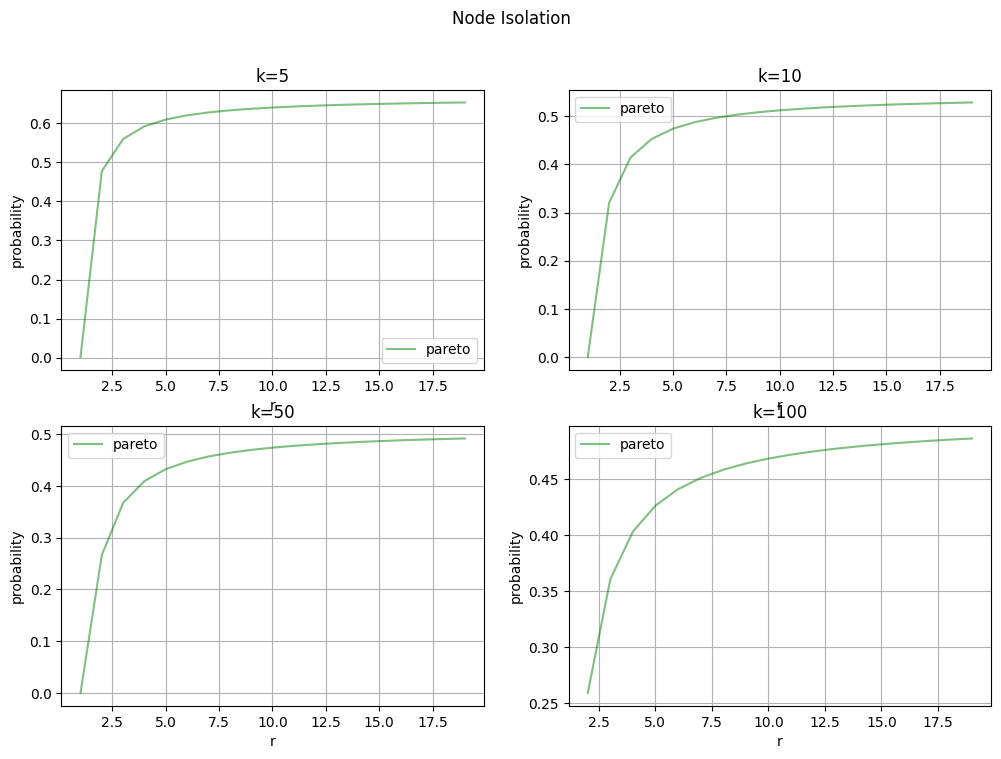

In [8]:
pareto_shape = 2.0
weibull_shape = 2.0
count_of_neighbors = (5, 10, 50, 100)
expon_lambda = 2

def plot_isolation_probabilities(k, r, axes):
    shape = np.arange(1.01, 20.0)
    pareto = np.array([pareto_isolation(k, r, i) for i in shape])
    axes.plot(shape, pareto, color='green', alpha=0.5, label='pareto')


fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()
fig.suptitle('Node Isolation')
for i, j in zip(ax, count_of_neighbors):
    plot_isolation_probabilities(k=j, r=j//2, axes=i)
    i.legend()
    i.grid(True)
    i.set_title(f'k={j}')
    i.set_xlabel('r')
    i.set_ylabel('probability')
# temp = is_more_nwue(expon(scale=(1/expon_lambda)), pareto(b=pareto_shape))
# print(temp)
# print(exponential_isolation(10, 7))
# print(pareto_isolation(10, 7, pareto_shape))

## Problem 3

Prove if $X$, $Y$, $T$ are random variables of Pareto, exponential and uniform distribution then $\pi_r(X) < \pi_r(Y) < \pi_r(T)$

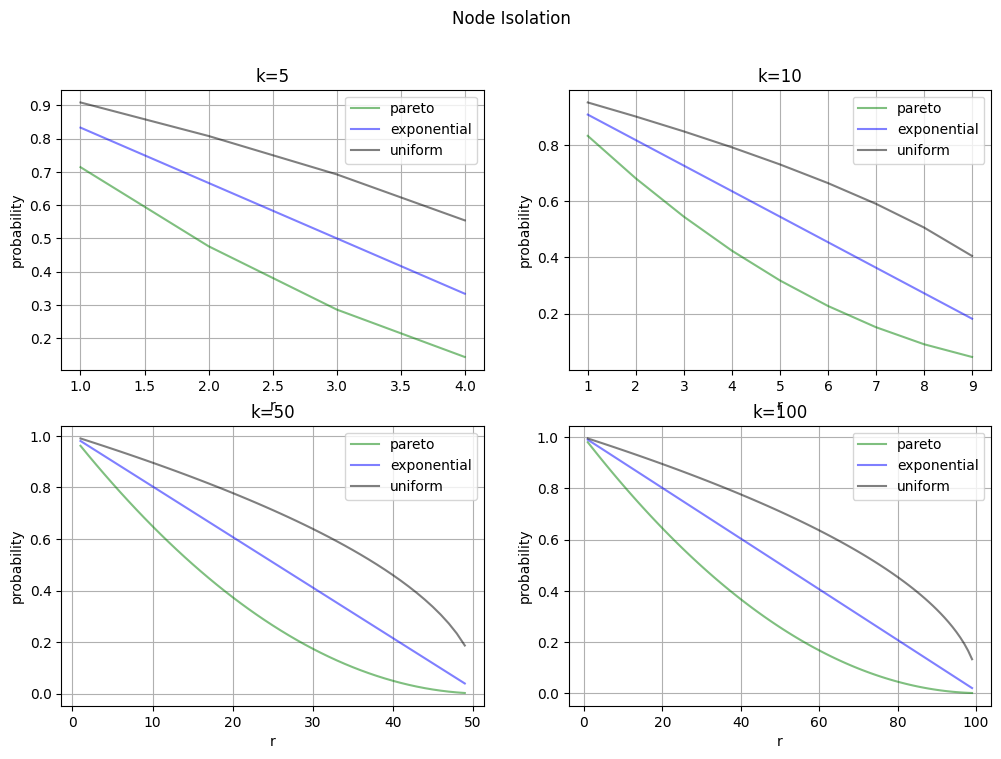

: 

In [15]:
def plot_isolation_probabilities(k, axes):
    r = np.arange(1, k)
    pareto = np.array([pareto_isolation(k, i, pareto_shape) for i in r])
    exponential = np.array([exponential_isolation(k, i) for i in r])
    uniform = np.array([uniform_isolation(k, i) for i in r])
    axes.plot(r, pareto, color='green', alpha=0.5, label='pareto')
    axes.plot(r, exponential, color='blue', alpha=0.5, label='exponential')
    axes.plot(r, uniform, color='black', alpha=0.5, label='uniform')


fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax = ax.flatten()
fig.suptitle('Node Isolation')
for i, j in zip(ax, count_of_neighbors):
    plot_isolation_probabilities(k=j, axes=i)
    i.legend()
    i.grid(True)
    i.set_title(f'k={j}')
    i.set_xlabel('r')
    i.set_ylabel('probability')

## Find NWUE-ness with Hypothesis Testing

$\beta(X)=\int_0^{\infty} \bar{F}^2(t) d t$

$\beta(Y)=\int_0^{\infty} \bar{G}^2(t) d t$

In [3]:
def beta(dist):
    return integrate.quad(lambda x: np.power(dist.sf(x), 2), 0, np.inf)[0]

$\Delta(X, Y)=\beta(X) / \mu_F-\beta(Y) / \mu_G$

In [4]:
def delta(dist_x, dist_y):
    return beta(dist_x) / dist_x.expect() - beta(dist_y) / dist_y.expect()

$S^2\left(X_n, Y_m\right)=\frac{m}{n+m} \cdot \frac{S^2\left(X_n\right)}{\bar{X}^2}+\frac{n}{n+m} \cdot \frac{S^2\left(Y_m\right)}{\bar{Y}^2}$

In [5]:
def s_2(dist_x, dist_y, n, m):
    return m / (n + m) * dist_x.var() / np.power(dist_x.expect(), 2) + n / (n + m) * dist_y.var() / np.power(dist_y.expect(), 2)

$T\left(X_n, Y_m\right)=\sqrt{\frac{n m}{n+m}} \cdot \frac{\Delta\left(X_n, Y_m\right)}{\sqrt{S^2\left(X_n, Y_m\right)}}$

In [6]:
def T(dist_x, dist_y, n, m):
    return np.sqrt(n * m / (n + m)) * delta(dist_x, dist_y) / np.sqrt(s_2(dist_x, dist_y, n, m))

## Problem 5

Define parameters:

In [7]:
pareto_shape = 20.0
weibull_shape = 20.0
pareto_scale = 10
weibull_scale = 10.7
expon_lambda = 2

pareto_dist = pareto(b=pareto_shape, scale=pareto_scale)
weibull_dist = weibull(c=weibull_shape, scale=weibull_scale)
expon_dist = expon(scale=(1/expon_lambda), loc=10)

Mean, median and NWUE value:

In [14]:
print(f'Pareto Mean: {pareto_dist.expect()}, Pareto Median: {pareto_dist.median()}')
print(f'Weibull Mean: {weibull_dist.expect()}, Weibull Median: {weibull_dist.median()}')
print(f'Exponential Mean: {expon_dist.expect()}, Exponential Median: {expon_dist.median()}')

print(f'NWUE Pareto-Weibull: {T(pareto_dist, weibull_dist, 30, 32)}')
print(f'NWUE Pareto-Exponential: {T(expon_dist, pareto_dist, 30, 32)}')
print(f'NWUE Weibull-Exponential: {T(expon_dist, weibull_dist, 30, 32)}')

Pareto Mean: 10.526315789473706, Pareto Median: 10.352649238413775
Weibull Mean: 10.416495641521697, Weibull Median: 10.505701349205927
Exponential Mean: 10.499999999999982, Exponential Median: 10.346573590279972
NWUE Pareto-Weibull: 0.5776177954266039
NWUE Pareto-Exponential: 0.14372282243713624
NWUE Weibull-Exponential: 0.733152015329698


What happen for NWUE value if the scale parameter is changed?

(0.0, 1.0)

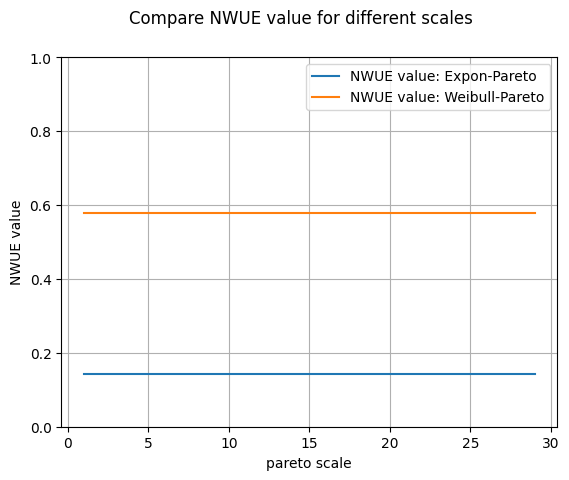

In [18]:
pareto_scale = np.arange(1, 30)
nwue_value_expon_pareto = np.array([T(expon_dist, pareto(b=pareto_shape, scale=i), 30, 32) for i in pareto_scale])
nwue_value_weibull_pareto = np.array([T(pareto(b=pareto_shape, scale=i), weibull_dist, 30, 32) for i in pareto_scale])

fig, ax = plt.subplots(1, 1)
fig.suptitle('Compare NWUE value for different scales')
ax.plot(pareto_scale, nwue_value_expon_pareto, label='NWUE value: Expon-Pareto')
ax.plot(pareto_scale, nwue_value_weibull_pareto, label='NWUE value: Weibull-Pareto')
ax.legend()
ax.grid(True)
ax.set_xlabel('pareto scale')
ax.set_ylabel('NWUE value')
ax.set_ylim(0, 1)